In [25]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# Import own packages
import sys
sys.path.append("/mnt/c/Users/vmangr/Documents/Code/sydr/")
from sydr.signal.gnsssignal import GenerateGPSGoldCode
from sydr.utils.constants import *


### Create a GNSS signal

In [26]:
def getPowerdB(value_linear):
    return 10 * np.log10(value_linear)

In [27]:
def getPowerLinear(value_dB):
    return 10 ** (value_dB/10)

In [28]:
def generateGPSL1CA(prn=1, samplingFrequency=None):
    # Generate PRN code
    prn_code = GenerateGPSGoldCode(prn=prn, samplingFrequency=samplingFrequency)

    # Generate doppler 
    # TODO 

    return prn_code


In [29]:
def addWhiteNoise(signal, sigma):

    noise = np.random.normal(0, scale=sigma, size=len(signal))
    
    #signal_out = signal + noise * sigma
    signal_out = signal + (noise - np.mean(noise))/np.std(noise)*sigma # From Simona's file
    #signal_out = signal + noise

    return signal_out

In [30]:
def correlate(signal_1, signal_2, method='scipy', normalize=False):

    # Normalization
    # From https://stackoverflow.com/questions/53436231/normalized-cross-correlation-in-python
    if normalize:
        signal_1 = (signal_1 - np.mean(signal_1)) / (np.std(signal_1) * len(signal_1))
        signal_2 = (signal_2 - np.mean(signal_2)) / (np.std(signal_2))

    # Swith correlation method
    match method:
        case 'scipy':
            corr = sp.signal.correlate(signal_1, signal_2, mode='full')
            lags = sp.signal.correlation_lags(len(signal_1), len(signal_2), mode="full")

    return corr, lags

In [31]:
def getSigmaFromSNR(signal, snr_target):

    # From: https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python
    
    # Get signal power
    signal_power = getdB(np.mean(signal**2)) 

    # Find suitable noiser power
    noise_power = signal_power - snr_target
    sigma = np.sqrt(10**((noise_power)/10))

    print(sigma)

    return sigma

In [32]:
def getSigmaFromCN0(signal_power_dB, cn0_target_dB):
    # From: Simona Lohan (TAU)

    noise_power = getPowerLinear(signal_power_dB) / getPowerLinear(cn0_target_dB)
    sigma = np.sqrt(noise_power)

    print(sigma)

    return sigma

In [33]:
# Parameters
prn = 1
samplingFrequency = 10e6
samplesPerChip = round(samplingFrequency / GPS_L1CA_CODE_FREQ)
snr_target = -17.6
#quantization_bits = 8

# Generate signals
signal = generateGPSL1CA(prn=prn, samplingFrequency=samplingFrequency)
#sigma_noise = getSigmaFromSNR(signal, snr_target)
sigma_noise = getSigmaFromCN0(signal_power_dB=0, cn0_target_dB=1)
signal_noisy = addWhiteNoise(signal, sigma=sigma_noise)

# Quantization 
# quantization_bins = bins = np.linspace(signal_noisy.min(), signal_noisy.max(), num=2**quantization_bits, endpoint=False)
# signal_noisy = np.digitize(signal_noisy, bins)

# Correlate
signal_corr, signal_lags = correlate(signal, signal)
signal_noisy_corr, signal_noisy_lags = correlate(signal, signal_noisy)


0.17782794100389226


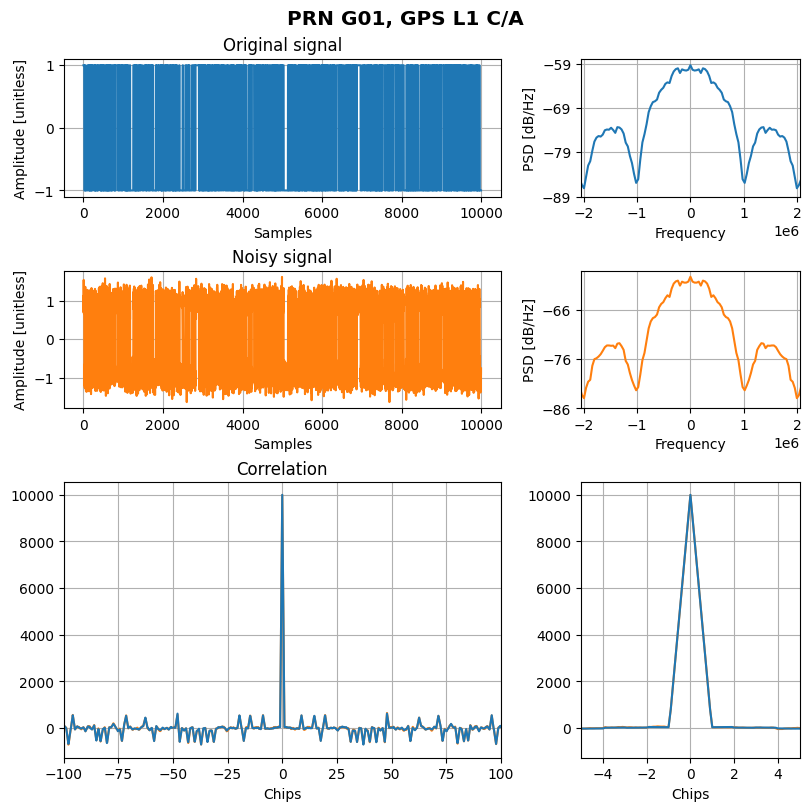

In [34]:
fig = plt.figure(figsize=(8, 8), layout="constrained")
spec = fig.add_gridspec(4, 3)

color_orignal = 'tab:blue'
color_noisy = 'tab:orange'
lim_corr_large = 100
lim_corr_small = 5
lim_psd = GPS_L1CA_CODE_FREQ*2

# Signal
fig.suptitle(f"PRN G{prn:02d}, GPS L1 C/A", size='x-large', fontweight='bold')

ax0 = fig.add_subplot(spec[0, 0:2])
ax0.plot(signal, color=color_orignal)
ax0.set_title("Original signal")
ax0.set_ylabel('Amplitude [unitless]')
ax0.set_xlabel('Samples')

ax1 = fig.add_subplot(spec[0, 2:])
ax1.psd(signal, Fs=samplingFrequency, sides='twosided', color=color_orignal)
ax1.set_ylabel("PSD [dB/Hz]")
ax1.set_xlim(-lim_psd, lim_psd)

# Noisy signal
ax2 = fig.add_subplot(spec[1, 0:2])
ax2.plot(signal_noisy, color=color_noisy)
ax2.set_title("Noisy signal")
ax2.set_ylabel('Amplitude [unitless]')
ax2.set_xlabel('Samples')

ax3 = fig.add_subplot(spec[1, 2:])
ax3.psd(signal_noisy, Fs=samplingFrequency, sides='twosided', color=color_noisy)
ax3.set_ylabel("PSD [dB/Hz]")
ax3.set_xlim(-lim_psd, lim_psd)

# Correlation
ax4 = fig.add_subplot(spec[2:, 0:2])
ax4.plot(signal_noisy_lags/samplesPerChip, signal_noisy_corr, color=color_noisy)
ax4.plot(signal_lags/samplesPerChip, signal_corr, color=color_orignal)
ax4.set_xlim(-lim_corr_large, lim_corr_large)
ax4.set_title("Correlation")
ax4.set_xlabel('Chips')

ax5 = fig.add_subplot(spec[2:, 2:])
ax5.plot(signal_noisy_lags/samplesPerChip, signal_noisy_corr, color=color_noisy)
ax5.plot(signal_lags/samplesPerChip, signal_corr, color=color_orignal)
ax5.set_xlim(-lim_corr_small, lim_corr_small)
ax5.set_xlabel('Chips')

axs = [ax0, ax1, ax2, ax3, ax4, ax5]

for ax in axs:
    ax.grid(visible=True)

## Filtering effects

In [35]:
F_s = 25.0e6               # Sampling Frequency
F_c = 3.123e6              # ?
T_c = 1/GPS_L1CA_CODE_FREQ # ?
B_f = 2.0e6                # Bandwidth

In [36]:
h_f = 

SyntaxError: invalid syntax (3730478360.py, line 1)

In [ ]:
d_theta = 0

# Mean
y_mean = np.exp(1j * d_theta)

: 